## Load data

In [3]:
import pandas as pd
import ast
import numpy as np

# Load in data
admissions = 'tedsa_puf_2019.csv'
df_raw = pd.read_csv(f'../../Downloads/{admissions}')

## Filter out select rows and columns

In [4]:
# Get count of original number of rows
old_rows = len(df_raw)

# Drop defined columns (year of admission, case id, geographic metro area, geographic division, geographic region)
columns_to_drop = ['ADMYR', 'CASEID', 'CBSA2010', 'DIVISION', 'REGION']
df = df_raw.drop(columns=columns_to_drop)
print(f'Dropped {len(columns_to_drop)} columns ({len(df.columns)} remain)')

# Drop values where dependent variable is unknown
df = df[df['METHUSE'] != -9]

# Only keep patients admitted with self-described use of an opioid as their primary substance use (i.e., SUB1 = 5, 6, or 7)
df = df[df['SUB1'].between(5, 7)]
new_rows = len(df)
percent_change = round(100*(old_rows-new_rows)/old_rows, 1)
print(f'Dropped {"{:,}".format(old_rows-new_rows)} observations or {percent_change}% of the data ({"{:,}".format(new_rows)} rows remain)')

df = df.reset_index(drop='index')

Dropped 5 columns (57 remain)
Dropped 1,340,233 observations or 71.9% of the data (524,134 rows remain)


## Balance dataset

In [5]:
# Split into two dataframes, printing result
df_ones = df[df['METHUSE']==1]
df_twos = df[df['METHUSE']==2]
print('Classes before down-sampling:', len(df_ones), len(df_twos))

# Sample down df_twos to the length of df_ones, printing result
ratio = len(df_ones)/len(df_twos)
df_twos = df_twos.sample(frac=ratio)
print('Classes after down-sampling:', len(df_ones), len(df_twos))

# Recombine and shuffle for good measure
df = pd.concat([df_ones, df_twos], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

Classes before down-sampling: 211743 312391
Classes after down-sampling: 211743 211743


## Make dataset human-readable

In [6]:
# Load in variable dictionary
with open('VariableDictionary.txt') as file:
    variable_dict_string = file.read()
    variable_dict = ast.literal_eval(variable_dict_string)

# Rename entries in column according to dictionary
df2 = df.copy()
for col, col_dict in variable_dict.items():
    if col in df2.columns:
        for old_value, new_value in variable_dict[col].items():
            df2[col] = df2[col].replace(old_value, new_value)

# Rename "-9" values as "Unknown"
for col in df2.columns:
    df2[col] = df2[col].replace(-9, 'Unknown')

# Merge DETNLF (detailed not in labor force) into EMPLOY==4 (not in labor force)
detailed_employ = []

for idx, value in df2.iterrows():
    if value['EMPLOY'] == 'NotInLaborForce':
        if value['DETNLF'] == 'Unknown':
            # Assign 'UnknownNotInLaborForce' if 'NotInLaborForce' and 'Unknown'
            detailed_employ.append('UnknownNotInLaborForce')
        else:
            # Otherwise, assign as the DETNLF value
            detailed_employ.append(value['DETNLF'])
    else:
        # Assign the EMPLOY value if not 'NotInLaborForce'
        detailed_employ.append(value['EMPLOY'])

# Add a new column for detailed employment and drop the two source columns
df2['DETEMPLOY'] = detailed_employ
df2 = df2.drop(columns=['EMPLOY', 'DETNLF'])

# Convert dependent variable to binary integer
df2['METHUSE'] = df2['METHUSE'].replace('MethUse', 1)
df2['METHUSE'] = df2['METHUSE'].replace('NoMethUse', 0)

# XGBoost and Shapley

### Make machine-readable dataset (encoding)

In [7]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

df4 = df2.copy()
# df4 = df4.sample(frac=0.1)  # small size for testing code

df4['STFIPS'] = df4['STFIPS'].astype('category').cat.codes
df4['EDUC'] = OrdinalEncoder(categories=[['Unknown', 'Grade8OrLess', 'Grade9To11', 'Grade12OrGED', '1To3yCollege', '4yCollegePlus']]).fit_transform(df4[['EDUC']])
df4['MARSTAT'] = df4['MARSTAT'].astype('category').cat.codes
df4['SERVICES'] = df4['SERVICES'].astype('category').cat.codes
df4['DETCRIM'] = df4['DETCRIM'].astype('category').cat.codes
df4['NOPRIOR'] = OrdinalEncoder(categories=[['Unknown', '0PriorTreatments', '1PriorTreatments', '2PriorTreatments', '3PriorTreatments',
                                            '4PriorTreatments', '5PlusPriorTreatments']]).fit_transform(df4[['NOPRIOR']])
df4['PSOURCE'] = df4['PSOURCE'].astype('category').cat.codes
df4['ARRESTS'] = OrdinalEncoder(categories=[['Unknown', '0Arrest', '1Arrest', '2PlusArrest']]).fit_transform(df4[['ARRESTS']])
# df4['METHUSE'] = df4['METHUSE'].astype('category').cat.codes
df4['PSYPROB'] = df4['PSYPROB'].astype('category').cat.codes
df4['PREG'] = df4['PREG'].astype('category').cat.codes
df4['GENDER'] = df4['GENDER'].astype('category').cat.codes
df4['VET'] = df4['VET'].astype('category').cat.codes
df4['LIVARAG'] = df4['LIVARAG'].astype('category').cat.codes
df4['DAYWAIT'] = OrdinalEncoder(categories=[['Unknown', '0DaysWait', '1To7DaysWait', '8To14DaysWait', '15To30DaysWait',
                                            '31PlusDaysWait']]).fit_transform(df4[['DAYWAIT']])
df4['DSMCRIT'] = df4['DSMCRIT'].astype('category').cat.codes
df4['AGE'] = OrdinalEncoder(categories=[['Age12To14', 'Age15To17', 'Age18To20', 'Age21To24', 'Age25To29', 'Age30To34', 'Age35To39', 'Age40To44',
                                        'Age45To49', 'Age50To54', 'Age55To64', 'Age65Plus' ]]).fit_transform(df4[['AGE']])
df4['RACE'] = df4['RACE'].astype('category').cat.codes
df4['ETHNIC'] = df4['ETHNIC'].astype('category').cat.codes
df4['PRIMINC'] = df4['PRIMINC'].astype('category').cat.codes
df4['SUB1'] = df4['SUB1'].astype('category').cat.codes
df4['SUB2'] = df4['SUB2'].astype('category').cat.codes
df4['SUB3'] = df4['SUB3'].astype('category').cat.codes
df4['ROUTE1'] = df4['ROUTE1'].astype('category').cat.codes
df4['ROUTE2'] = df4['ROUTE2'].astype('category').cat.codes
df4['ROUTE3'] = df4['ROUTE3'].astype('category').cat.codes
df4['FREQ1'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ1']])
df4['FREQ2'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ2']])
df4['FREQ3'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ3']])
df4['FRSTUSE1'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE1']])
df4['FRSTUSE2'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE2']])
df4['FRSTUSE3'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE3']])
df4['HLTHINS'] = df4['HLTHINS'].astype('category').cat.codes
df4['PRIMPAY'] = df4['PRIMPAY'].astype('category').cat.codes
df4['FREQ_ATND_SELF_HELP'] = OrdinalEncoder(categories=[['Unknown', 'NoAttendance', 'SomeAttendance', '1To3TimesPastMonth', '4To7TimesPastMonth',
                                                        '8To30TimesPastMonth']]).fit_transform(df4[['FREQ_ATND_SELF_HELP']])
df4['ALCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['ALCFLG']])
df4['COKEFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['COKEFLG']])
df4['MARFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MARFLG']])
df4['HERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HERFLG']])
df4['METHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['METHFLG']])
df4['OPSYNFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OPSYNFLG']])
df4['PCPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['PCPFLG']])
df4['HALLFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HALLFLG']])
df4['MTHAMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MTHAMFLG']])
df4['AMPHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['AMPHFLG']])
df4['STIMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['STIMFLG']])
df4['BENZFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BENZFLG']])
df4['TRNQFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['TRNQFLG']])
df4['BARBFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BARBFLG']])
df4['SEDHPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['SEDHPFLG']])
df4['INHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['INHFLG']])
df4['OTCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTCFLG']])
df4['OTHERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTHERFLG']])
# df4['DIVISION'] = df4['DIVISION'].astype('category').cat.codes
# df4['REGION'] = df4['REGION'].astype('category').cat.codes
df4['IDU'] = OrdinalEncoder(categories=[['NoIDU', 'IDU']]).fit_transform(df4[['IDU']])
df4['ALCDRUG'] = OrdinalEncoder(categories=[['OtherDrugs', 'AlcoholAndDrugs']]).fit_transform(df4[['ALCDRUG']])
df4['DETEMPLOY'] = df4['DETEMPLOY'].astype('category').cat.codes

In [8]:
# # Show the share of observations by state
# df2.groupby('STFIPS').count()/len(df2)

## Train XG Boost model

In [9]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X = df4.drop('METHUSE', axis=1)
y = df4['METHUSE'].astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [10]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Search the parameter grid
# Docs: https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook#2.-XGBoost-hyperparameters-
space={'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.01),
       'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
       'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
       'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
       'max_depth': hp.quniform("max_depth", 3, 27, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.choice('n_estimators', range(100, 1000)),
       'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
       'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
       'subsample': hp.quniform('subsample', 0.5, 1, 0.05)
    }

def objective(space):
    clf=xgb.XGBClassifier(colsample_bytree=round(space['colsample_bytree'], 0),
                          early_stopping_rounds=10,
                          eta=space['eta'],
                          eval_metric='auc',
                          gamma=space['gamma'],
                          learning_rate=space['learning_rate'],
                          max_depth=int(round(space['max_depth'], 0)),
                          min_child_weight=space['min_child_weight'],
                          n_estimators=space['n_estimators'],
                          objective='binary:logistic',
                          reg_alpha=space['reg_alpha'],
                          reg_lambda=space['reg_lambda'],
                          seed=24,
                          subsample=round(space['subsample'], 0))

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train, y_train, eval_set=evaluation, verbose=False)

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", round(accuracy, 3))
    return {'loss': -accuracy, 'status': STATUS_OK }

In [30]:
# Begin training
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,          # <-- bring back to 50
                        trials = trials)

SCORE:                                                 
0.841                                                  
SCORE:                                                                            
0.838                                                                             
SCORE:                                                                            
0.834                                                                             
SCORE:                                                                            
0.846                                                                             
SCORE:                                                                            
0.84                                                                              
SCORE:                                                                            
0.845                                                                             
SCORE:                                                    

In [11]:
"""
# Best from 100 runs (50 would have done just fine)

{'colsample_bytree': 0.55,
 'eta': 0.15000000000000002,
 'gamma': 0.8,
 'learning_rate': 0.27,
 'max_depth': 20.0,
 'min_child_weight': 3.0,
 'n_estimators': 598,
 'reg_alpha': 40.0,
 'reg_lambda': 0.38166847419409755,
 'subsample': 0.6000000000000001}

 {'colsample_bytree': 0.61,
 'eta': 0.25,
 'gamma': 0.8,
 'learning_rate': 0.22,
 'max_depth': 16.0,
 'min_child_weight': 0.0,
 'n_estimators': 812,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9241629285526229,
 'subsample': 0.9}
"""

best_hyperparams = {'colsample_bytree': 0.61,
                     'eta': 0.25,
                     'gamma': 0.8,
                     'learning_rate': 0.22,
                     'max_depth': 16.0,
                     'min_child_weight': 0.0,
                     'n_estimators': 812,
                     'reg_alpha': 40.0,
                     'reg_lambda': 0.9241629285526229,
                     'subsample': 0.9}

best_hyperparams

{'colsample_bytree': 0.61,
 'eta': 0.25,
 'gamma': 0.8,
 'learning_rate': 0.22,
 'max_depth': 16.0,
 'min_child_weight': 0.0,
 'n_estimators': 812,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9241629285526229,
 'subsample': 0.9}

In [13]:
# import xgboost as xgb
# import shap
# import numpy as np
#
# # Train XGBoost model
# model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=24)
# model.fit(X_train, y_train)

In [14]:
# stop

### Interpretability

In [15]:
import shap
import numpy as np

best_hyperparams_formatted = best_hyperparams.copy()
best_hyperparams_formatted['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams_formatted['eval_metric'] = 'auc'
best_hyperparams_formatted['objective'] = 'binary:logistic'
best_hyperparams_formatted['seed'] = 24

best_model = xgb.XGBClassifier(**best_hyperparams_formatted)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.61, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.25, eval_metric='auc',
              feature_types=None, gamma=0.8, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.22, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=16,
              max_leaves=None, min_child_weight=0.0, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=812,
              n_jobs=None, num_parallel_tree=None, ...)

In [16]:
# from sklearn.metrics import accuracy_score
#
# # Assuming you have already trained the model and made predictions as shown in the previous example
# # y_pred contains the predicted class labels (0 or 1) or probabilities
#
# # Convert predicted probabilities to class labels (0 or 1)
# y_pred = best_model.predict(X_test)
# y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]
#
# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f'Accuracy on the testing data: {accuracy}')

In [17]:
# Generate Shapley values
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test) # change to X_test

[19:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [18]:
shap_values   # Can we export these values as a csv? Trying to find a way to not have to run them each time

.values =
array([[-1.7404778e+00, -4.1082469e-03,  4.1304093e-02, ...,
        -1.4427603e-02,  5.9829680e-03, -1.3749576e-01],
       [-2.3158967e+00,  3.3322457e-02, -2.7893627e-01, ...,
         2.7248016e-02,  6.6644903e-03, -3.9639946e-02],
       [-1.7632731e+00, -1.0290778e-02,  2.9730525e-02, ...,
        -2.7645594e-03,  6.0550719e-03, -5.2783541e-02],
       ...,
       [-6.5731722e-01, -1.4291168e-02, -1.0602211e-01, ...,
        -1.0670650e-02,  2.9527931e-03, -1.0297690e-02],
       [-1.2164551e-01,  3.4802392e-02,  6.1159015e-02, ...,
        -3.0928228e-02,  6.2047630e-03,  2.8228542e-02],
       [-1.1291826e+00, -1.3688355e-02,  3.9266651e-03, ...,
         5.0716352e-02,  1.3846613e-03, -4.4096172e-02]], dtype=float32)

.base_values =
array([-0.01115074, -0.01115074, -0.01115074, ..., -0.01115074,
       -0.01115074, -0.01115074], dtype=float32)

.data =
array([[26.,  4.,  2., ...,  1.,  0.,  7.],
       [ 6.,  2.,  4., ...,  1.,  0.,  7.],
       [26.,  3.,  1., ..., 

In [19]:
import os
os.system('say "Work complete"')

0

In [20]:
def absolute_share(input_list):
    absolute_list = [abs(i) for i in input_list]
    absolute_share_list = [j/sum(absolute_list) for j in absolute_list]
    return absolute_share_list

# Show table of top Shapley values
feature_names = X_test.columns
result = pd.DataFrame(shap_values.values, columns=feature_names, index=X_test.index)
# result.to_csv('shapley_results.csv', index=False)

values = np.abs(result.values).mean(0)
abs_values = absolute_share(np.abs(result.values).mean(0))
shap_importance = pd.DataFrame(list(zip(feature_names, values, abs_values)), columns=['feature_name','feature_importance', 'abs_feature_importance'])
shap_importance.sort_values(by=['feature_importance'], ascending=False, inplace=True)
shap_importance.reset_index(drop=True)

,feature_name,feature_importance,abs_feature_importance
0,SERVICES,1.174550,0.248819
1,STFIPS,0.868761,0.184040
2,PSOURCE,0.290875,0.061620
3,NOPRIOR,0.258124,0.054682
4,FREQ1,0.169827,0.035977
5,DSMCRIT,0.122623,0.025977
6,HLTHINS,0.122367,0.025923
7,PSYPROB,0.107691,0.022814
8,PRIMPAY,0.103206,0.021863
9,AGE,0.095984,0.020333


In [51]:
# (-0.1199*12982 + -0.0953*13336 + 0.0634*53816 + -0.0368*4564)/(12982 + 13336 + 53816 + 4564)
(0.1295*12982 + 0.0995*13336 + 0.0641*53816 + 0.0630*4564)/(12982 + 13336 + 53816 + 4564)

0.07963869985123616

In [22]:
livarag_dict = {0:'DependLiving', 1:'Homeless', 2:'IndependentLiving', 3:'Unknown'}
print(livarag_dict)
X_test.value_counts('LIVARAG')
# df2.value_counts('LIVARAG')

{0: 'DependLiving', 1: 'Homeless', 2: 'IndependentLiving', 3: 'Unknown'}


LIVARAG
2    53816
1    13336
0    12982
3     4564
Name: count, dtype: int64

In [56]:
# result = pd.read_csv('shapley_results.csv')
result_homeless = result.copy()
result_homeless.insert(0, 'homeless', X_test['LIVARAG'])
result_homeless.insert(1, 'absolute_livarag', abs(result_homeless['LIVARAG']))
result_homeless_grouped = result_homeless.groupby('homeless').mean()[['LIVARAG', 'absolute_livarag']]
result_homeless_var = result_homeless_grouped.iloc[0]['LIVARAG']
result_homeless_grouped

,LIVARAG,absolute_livarag
homeless,,
0,-0.119941,0.129485
1,-0.095273,0.099458
2,0.063370,0.064133
3,-0.036754,0.063048


In [70]:
# Group by state
result_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'homeless_shapley'})
df2_homeless = df2[df2['LIVARAG']=='Homeless'][['STFIPS']]
result_state = pd.merge(result_shapley, df2_homeless, how='inner', left_index=True, right_index=True)

# Calculate state average, std, coefficient of variation of shapley values
# homeless_shapley_stdev = result_state['homeless_shapley'].std()
# print('Shapley value standard deviation: ', homeless_shapley_stdev)
result_state_mean = result_state.groupby('STFIPS').mean()
result_state_mean = result_state_mean.rename(columns={'homeless_shapley': 'avg_homeless_shapley'})
result_state_mean['overall_homeless_shapley'] = result_homeless_var
result_state_mean['pct_diff_homeless_shapley'] = (result_state_mean['overall_homeless_shapley'] - result_state_mean['avg_homeless_shapley'])/result_state_mean['overall_homeless_shapley']
# result_state_std = result_state.groupby('STFIPS').std()
# result_state_std = result_state_std.rename(columns={'homeless_shapley': 'std_homeless_shapley'})
# result_state = pd.merge(result_state_mean, result_state_std, left_index=True, right_index=True)
# result_state['coefficient_of_variation'] = result_state['std_homeless_shapley']/result_state['avg_homeless_shapley']

# Save, print results
# result_state_mean.to_csv('shap_importance_by_state.csv')
result_state_mean

,avg_homeless_shapley,overall_homeless_shapley,pct_diff_homeless_shapley
STFIPS,,,
AK,-0.055369,-0.119941,0.538361
AL,-0.056504,-0.119941,0.528897
AR,-0.066819,-0.119941,0.442901
CA,-0.185559,-0.119941,-0.547090
CO,-0.037049,-0.119941,0.691104
CT,-0.128063,-0.119941,-0.067714
DC,-0.097710,-0.119941,0.185351
DE,-0.131351,-0.119941,-0.095130
GA,-0.103668,-0.119941,0.135673


# Plot Shapley values

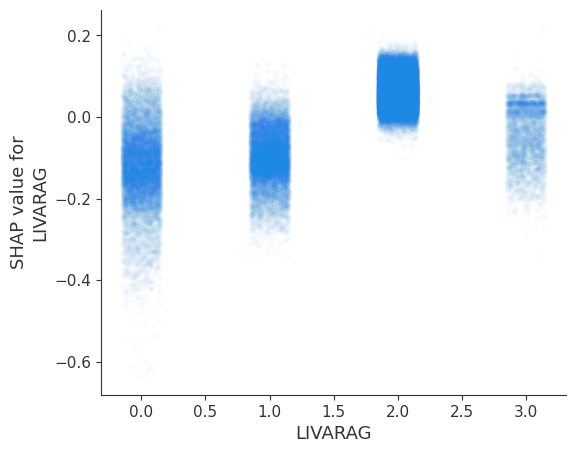

In [37]:
# Show dependence plots for the top n features across all observations
# NOTE: In order to get dependence plot to work, you must revert to matplotlib==3.1.3
# Examples of dependence plots: https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

shap.dependence_plot('LIVARAG', shap_values.values, X_test, x_jitter=0.3, alpha=0.02, interaction_index=None)

In [29]:
shap_importance
# shap_importance.to_csv('shap_importance.csv', index=False)

,feature_name,feature_importance,abs_feature_importance
3,SERVICES,1.174550,0.248819
0,STFIPS,0.868761,0.184040
6,PSOURCE,0.290875,0.061620
5,NOPRIOR,0.258124,0.054682
25,FREQ1,0.169827,0.035977
14,DSMCRIT,0.122623,0.025977
31,HLTHINS,0.122367,0.025923
8,PSYPROB,0.107691,0.022814
32,PRIMPAY,0.103206,0.021863
15,AGE,0.095984,0.020333


# Grouped feature importance

In [1]:
import pandas as pd
g = pd.read_csv('shap_importance_encoded.csv')  #update label and category, then regroup
g

,feature_name,feature_label,feature_category,feature_importance,abs_feature_importance
0,AGE,age,demographic,0.095984,0.020333
1,ALCDRUG,substance use type,substance use history,0.007010,0.001485
2,ALCFLG,alcohol,substance use history,0.023254,0.004926
3,AMPHFLG,amphetamines,substance use history,0.001574,0.000334
4,ARRESTS,arrests,personal history,0.085401,0.018092
5,BARBFLG,barbiturates,substance use history,0.000059,0.000013
6,BENZFLG,benzodiazepines,substance use history,0.005307,0.001124
7,COKEFLG,cocaine,substance use history,0.011707,0.002480
8,DAYWAIT,days waiting,coordination of care,0.081339,0.017231
9,DETCRIM,ciminal justice referral,coordination of care,0.063934,0.013544


In [4]:
g_grouped = g.groupby('feature_category').sum()['abs_feature_importance'].sort_values(ascending=False)
# g_grouped.to_csv('shap_importance_grouped.csv')
g_grouped

feature_category
coordination of care     0.341214
geographic               0.184040
substance use history    0.176852
medical history          0.131877
economic                 0.097882
personal history         0.035360
demographic              0.032774
Name: abs_feature_importance, dtype: float64

In [3]:
g.sort_values(by='abs_feature_importance', ascending=False)[['feature_label', 'abs_feature_importance']].reset_index(drop=True)

,feature_label,abs_feature_importance
0,treatment service,0.248819
1,state code,0.184040
2,referral source,0.061620
3,prior treatments,0.054682
4,primary frequency,0.035977
5,dsm diagnosis,0.025977
6,health insurance,0.025923
7,mental disorder,0.022814
8,payment source,0.021863
9,age,0.020333
